Let's start by annotating muscle:

Extracting EDF parameters from f:\WEBSITE\EDF_analysis\EDF+\103918\103918.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...  1124.992 secs...


Raw data loaded. Number of channels: 127, Sampling frequency: 128.0 Hz
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Selected EEG channels: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Standard 10-20 montage applied.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transiti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 213 samples (1.664 s)

Muscle artifacts annotated with z-score threshold=1. Merged with video events.
Used Annotations descriptions: [np.str_('1'), np.str_('12'), np.str_('2'), np.str_('3'), np.str_('BAD_muscle')]


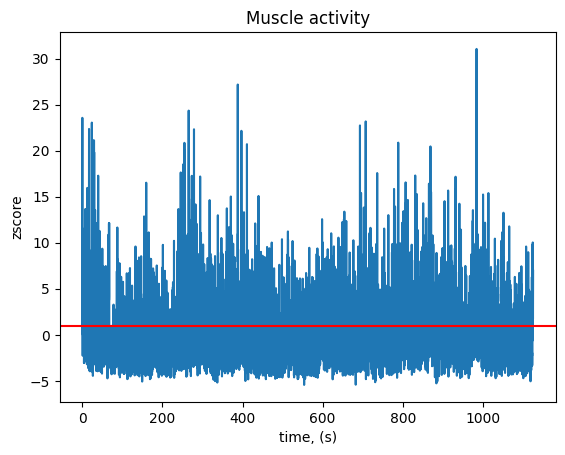

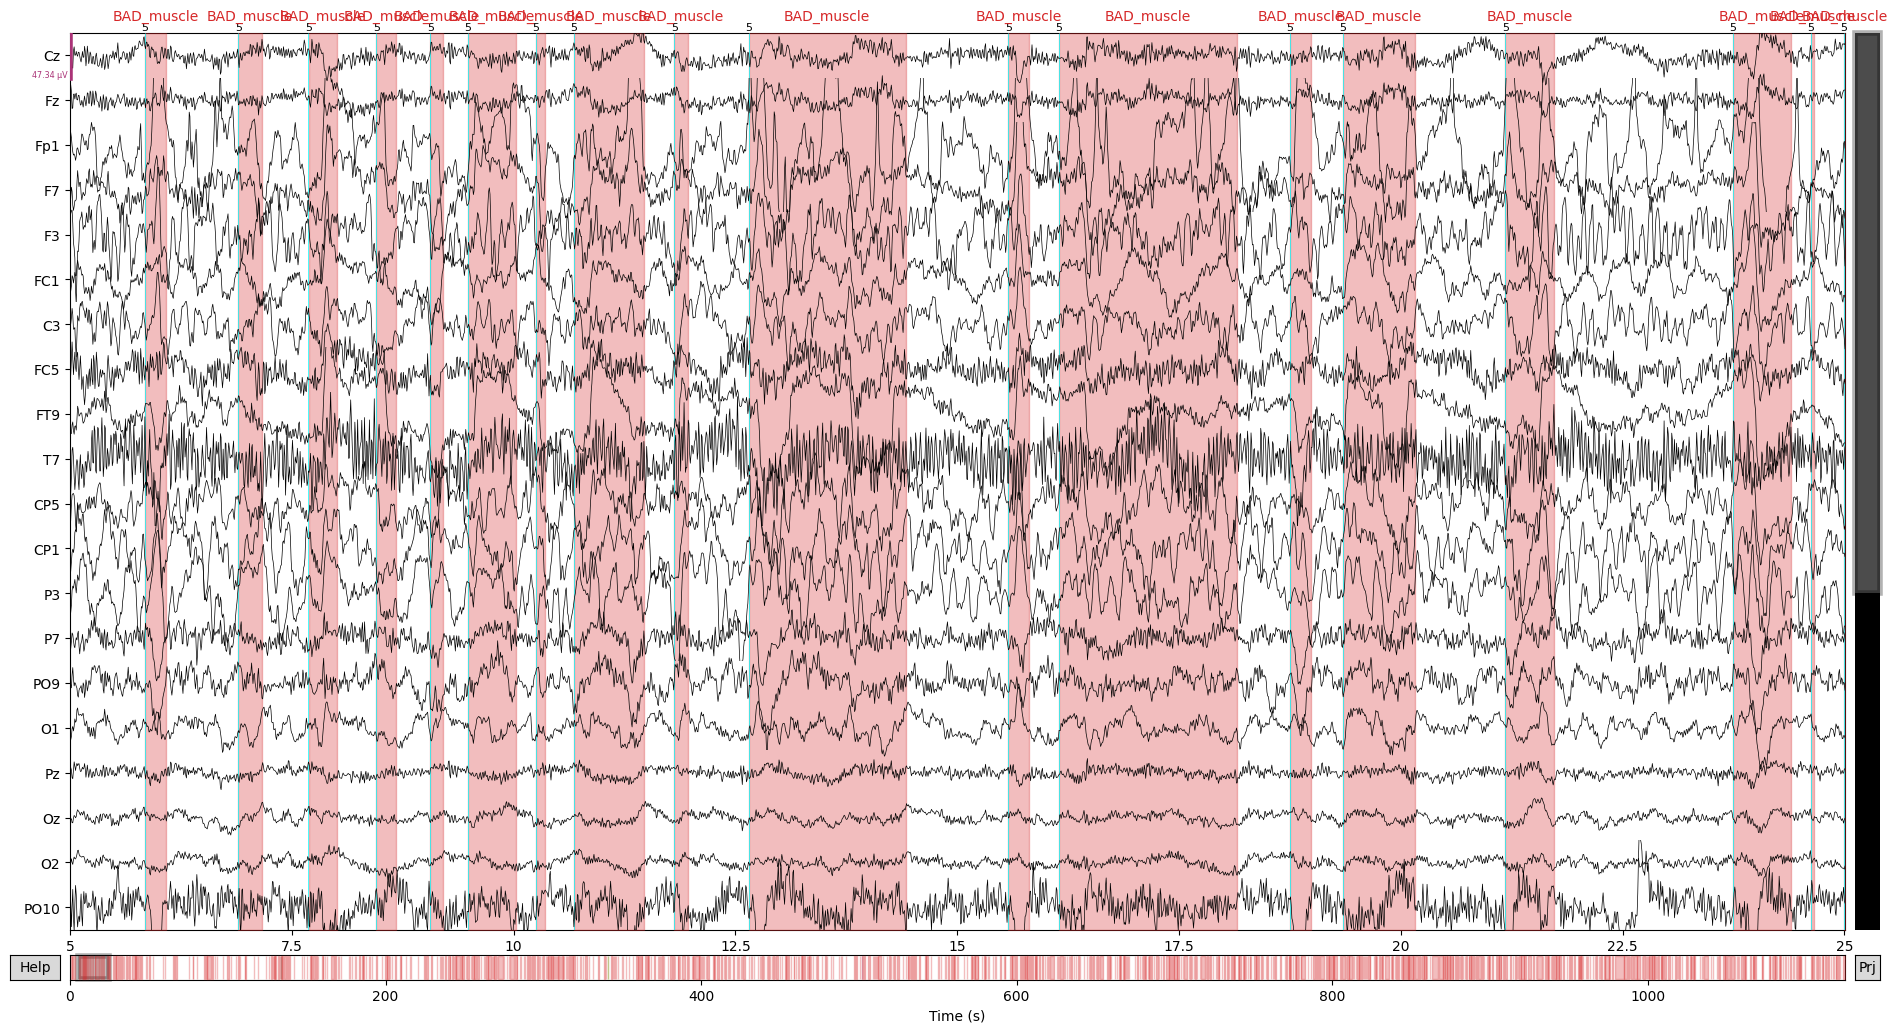

Plotted raw EEG data with annotations and events.


In [29]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Read your EDF file
raw = mne.io.read_raw_edf(r'EDF+\103918\103918.edf', preload=True)
print(f"Raw data loaded. Number of channels: {len(raw.ch_names)}, Sampling frequency: {raw.info['sfreq']} Hz")

# Select EEG channels
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
raw.pick_channels(eeg_channels)
print(f"Selected EEG channels: {eeg_channels}")

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')
print("Standard 10-20 montage applied.")

# Apply preprocessing steps
raw.set_eeg_reference('average', projection=True)
raw.filter(l_freq=1, h_freq=40)
print("Applied average reference and band-pass filter (1 - 40 Hz).")

# Annotate muscle artifacts using z-score
threshold_muscle = 1  # z-score
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw,
    ch_type="eeg",
    threshold=threshold_muscle,
    min_length_good=0.2,
    filter_freq=[1, 63],
)

# Print and plot muscle activity
fig, ax = plt.subplots()
ax.plot(raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color="r")
ax.set(xlabel="time, (s)", ylabel="zscore", title="Muscle activity")

# Define baseline period (0 to 30 seconds)
baseline_start = 0
baseline_end = 30
sfreq = raw.info['sfreq']  # Get the sampling frequency

# Extract baseline period
baseline_data, _ = raw[:, int(baseline_start * sfreq):int(baseline_end * sfreq)]

# Merge events function
def merge_events(events, event_indices, new_event_code, replace_events=True):
    """
    Merge specific events in the events array with a new event code.

    Parameters:
    events : list of lists
        List of events where each event is represented as [onset_sample, duration, event_code].
    event_indices : list
        List of indices indicating which events to merge with the new_event_code.
    new_event_code : int
        New event code to assign to merged events.
    replace_events : bool, optional
        If True, replace the original events with the merged events. If False,
        keep the original events and add merged events.

    Returns:
    merged_events : numpy.ndarray
        Array of merged events with the specified changes.
    """
    merged_events = []
    
    for event in events:
        onset_sample, duration, event_code = event
        
        if event_code in event_indices:
            if replace_events:
                event = [onset_sample, duration, new_event_code]
            else:
                merged_events.append([onset_sample, duration, new_event_code])
        
        merged_events.append(event)
    
    return np.array(merged_events)

# Merge muscle artifacts annotations with video events
if annot_muscle is not None:
    # Combine annotations with merged events
    combined_annotations = annot_muscle.copy()  # Create a copy of muscle annotations
    for event in merged_events_keep:
        onset_sample, duration, event_code = event
        combined_annotations.append(onset_sample, duration, description=str(event_code))

    raw.set_annotations(combined_annotations)
    print(f"Muscle artifacts annotated with z-score threshold={threshold_muscle}. Merged with video events.")

# Plot raw data with annotations
events_from_annot = mne.events_from_annotations(raw, event_id=None, regexp=None, use_rounding=False)[0]
order = np.arange(0, len(raw.ch_names))  # Replace with your valid channel indices
raw.plot(start=5, duration=20, order=order, title='Raw EEG Data with Annotations', scalings='auto', events=events_from_annot)

plt.show()

print("Plotted raw EEG data with annotations and events.")


We can also do something similar with eye blinks, but they don't get a range marked like above

Extracting EDF parameters from f:\WEBSITE\EDF_analysis\EDF+\103918\103918.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...  1124.992 secs...
Raw data loaded. Number of channels: 127, Sampling frequency: 128.0 Hz
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Selected EEG channels: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
Standard 10-20 montage applied.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 20 components
Fitting ICA took 4.1s.
ICA fitting done.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Identified EOG artifacts: [np.int64(0), np.int64(1)]
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [ 2 31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 465 significant peaks
Number of EOG events detected: 465
Not setting metadata
465 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
Using data from p

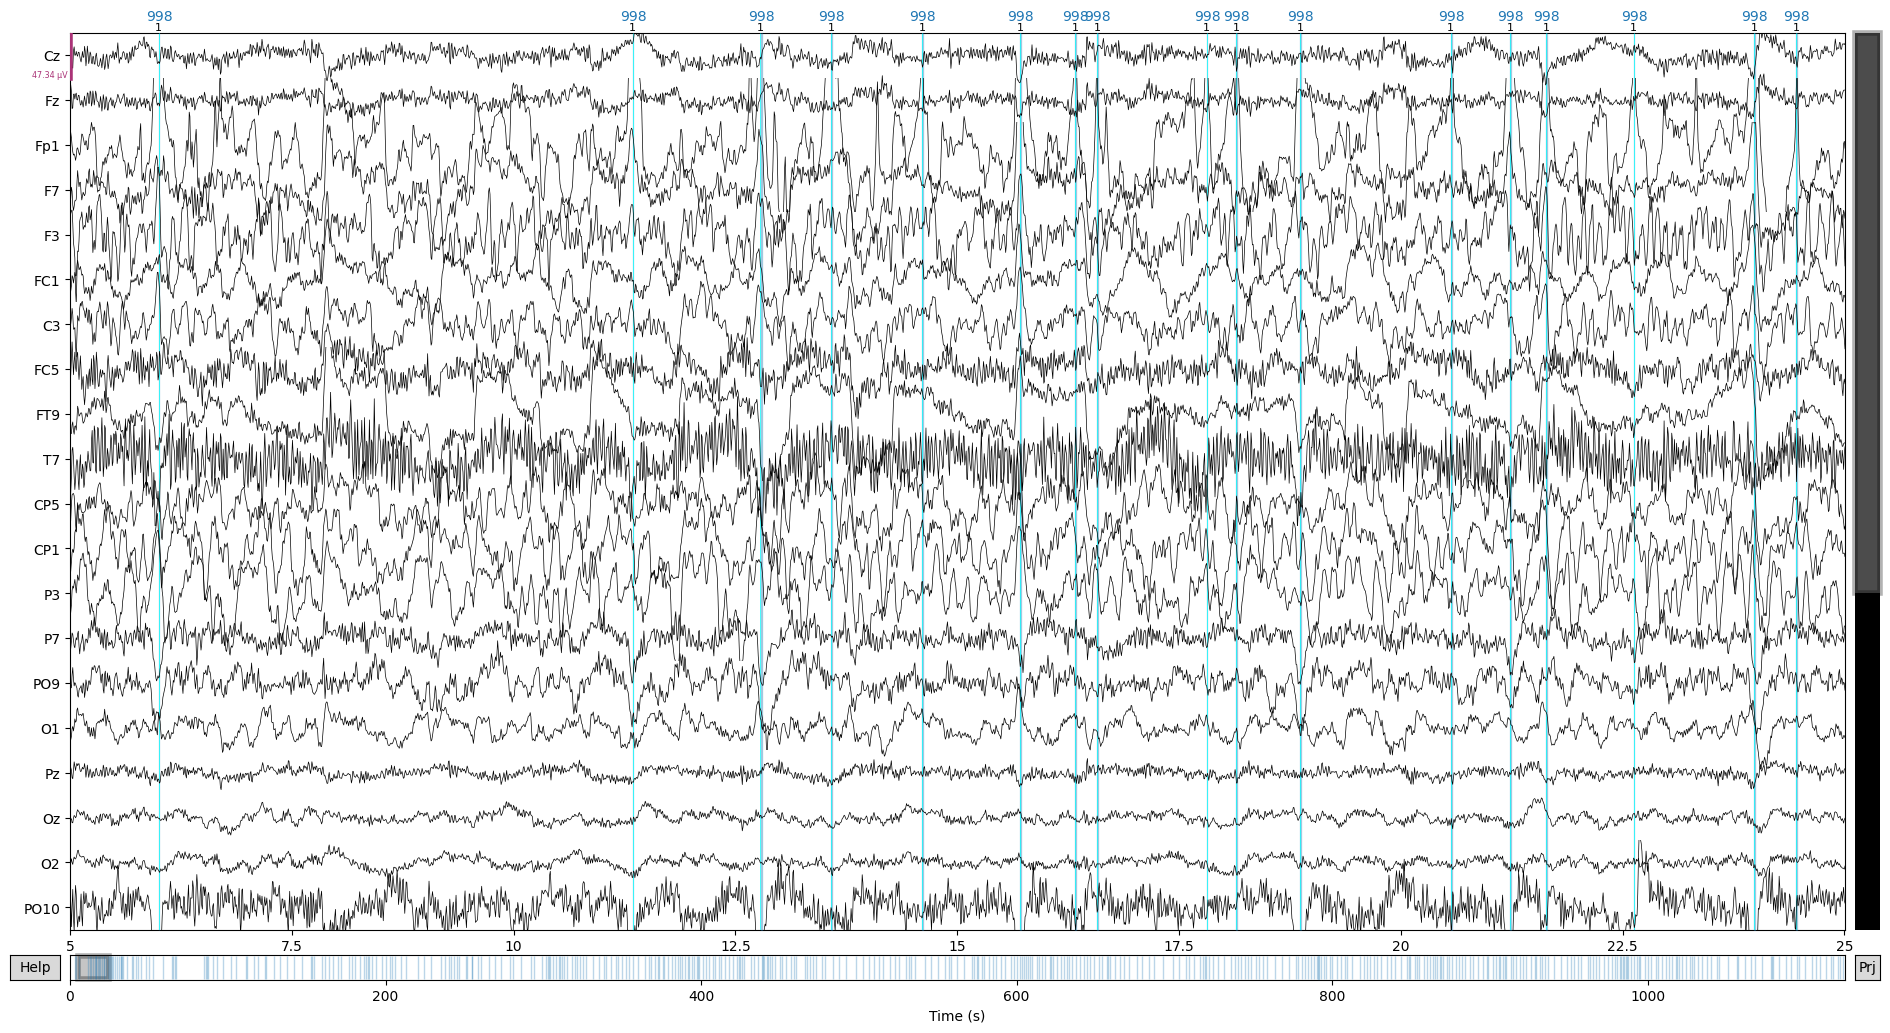

Plotted raw EEG data with EOG annotations.


In [21]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Read your EDF file
raw = mne.io.read_raw_edf(r'EDF+\103918\103918.edf', preload=True)
print(f"Raw data loaded. Number of channels: {len(raw.ch_names)}, Sampling frequency: {raw.info['sfreq']} Hz")

# Select EEG channels
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
raw.pick_channels(eeg_channels)
print(f"Selected EEG channels: {eeg_channels}")

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')
print("Standard 10-20 montage applied.")

# Apply preprocessing steps
raw.set_eeg_reference('average', projection=True)
raw.filter(l_freq=1, h_freq=40)
print("Applied average reference and band-pass filter (1 - 40 Hz).")

# Perform ICA to identify and remove EOG artifacts
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
print("ICA fitting done.")

# Find EOG artifacts using Fp1 and Fp2 channels
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'])
print(f"Identified EOG artifacts: {eog_indices}")

# Mark EOG events in the raw data
eog_events = mne.preprocessing.create_eog_epochs(raw, ch_name=['Fp1', 'Fp2']).events
eog_annot = mne.annotations_from_events(eog_events, sfreq=raw.info['sfreq'], orig_time=raw.info['meas_date'])

# Set annotations to only include EOG events
raw.set_annotations(eog_annot)

# Plot raw data with annotations
events_from_annot = mne.events_from_annotations(raw, event_id=None, regexp=None, use_rounding=False)[0]
order = np.arange(0, len(raw.ch_names))  # Replace with your valid channel indices
raw.plot(start=5, duration=20, order=order, title='Raw EEG Data with EOG Annotations', scalings='auto', events=events_from_annot)

plt.show()

print("Plotted raw EEG data with EOG annotations.")


## It can be a hassle to auto annotate by amplitude, so we can get peak to peak
values first then use those for our later code!  That is why this is complicated!  We first find
the peak to peak values for every channel then use those to annotate high amplitudes

Extracting EDF parameters from f:\WEBSITE\EDF_analysis\EDF+\Zacker\Zacker.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 139775  =      0.000 ...  1091.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwid

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Trying peak: 1.2880367780651622e-05 for channel: Fz
Finding segments below or above PTP threshold.
Trying peak: 2.2714686517918732e-05 for channel: Fp1
Finding segments below or above PTP threshold.
Trying peak: 1.1808408142760531e-05 for channel: F7
Finding segments below or above PTP threshold.
Trying peak: 1.2738938841907227e-05 for channel: F3
Finding segments below or above PTP threshold.
Trying peak: 1.2767779185050876e-05 for channel: FC1
Finding segments below or above PTP threshold.
Trying peak: 9.089420585096832e-06 for channel: C3
Finding segments below or above PTP threshold.
Trying peak: 1.236418862591457e-05 for channel: FC5
Finding segments below or above PTP threshold.
Trying peak: 1.1482639755535438e-05 for channel: FT9
Finding segments below or above PTP threshold.
Trying peak: 1.2495693406756453e-05 for channel: T7
Finding segments below or above PTP threshold.
Trying peak: 1.1051047590224213e-05 for channel: CP5
Finding segments below or above PTP threshold.
Trying 

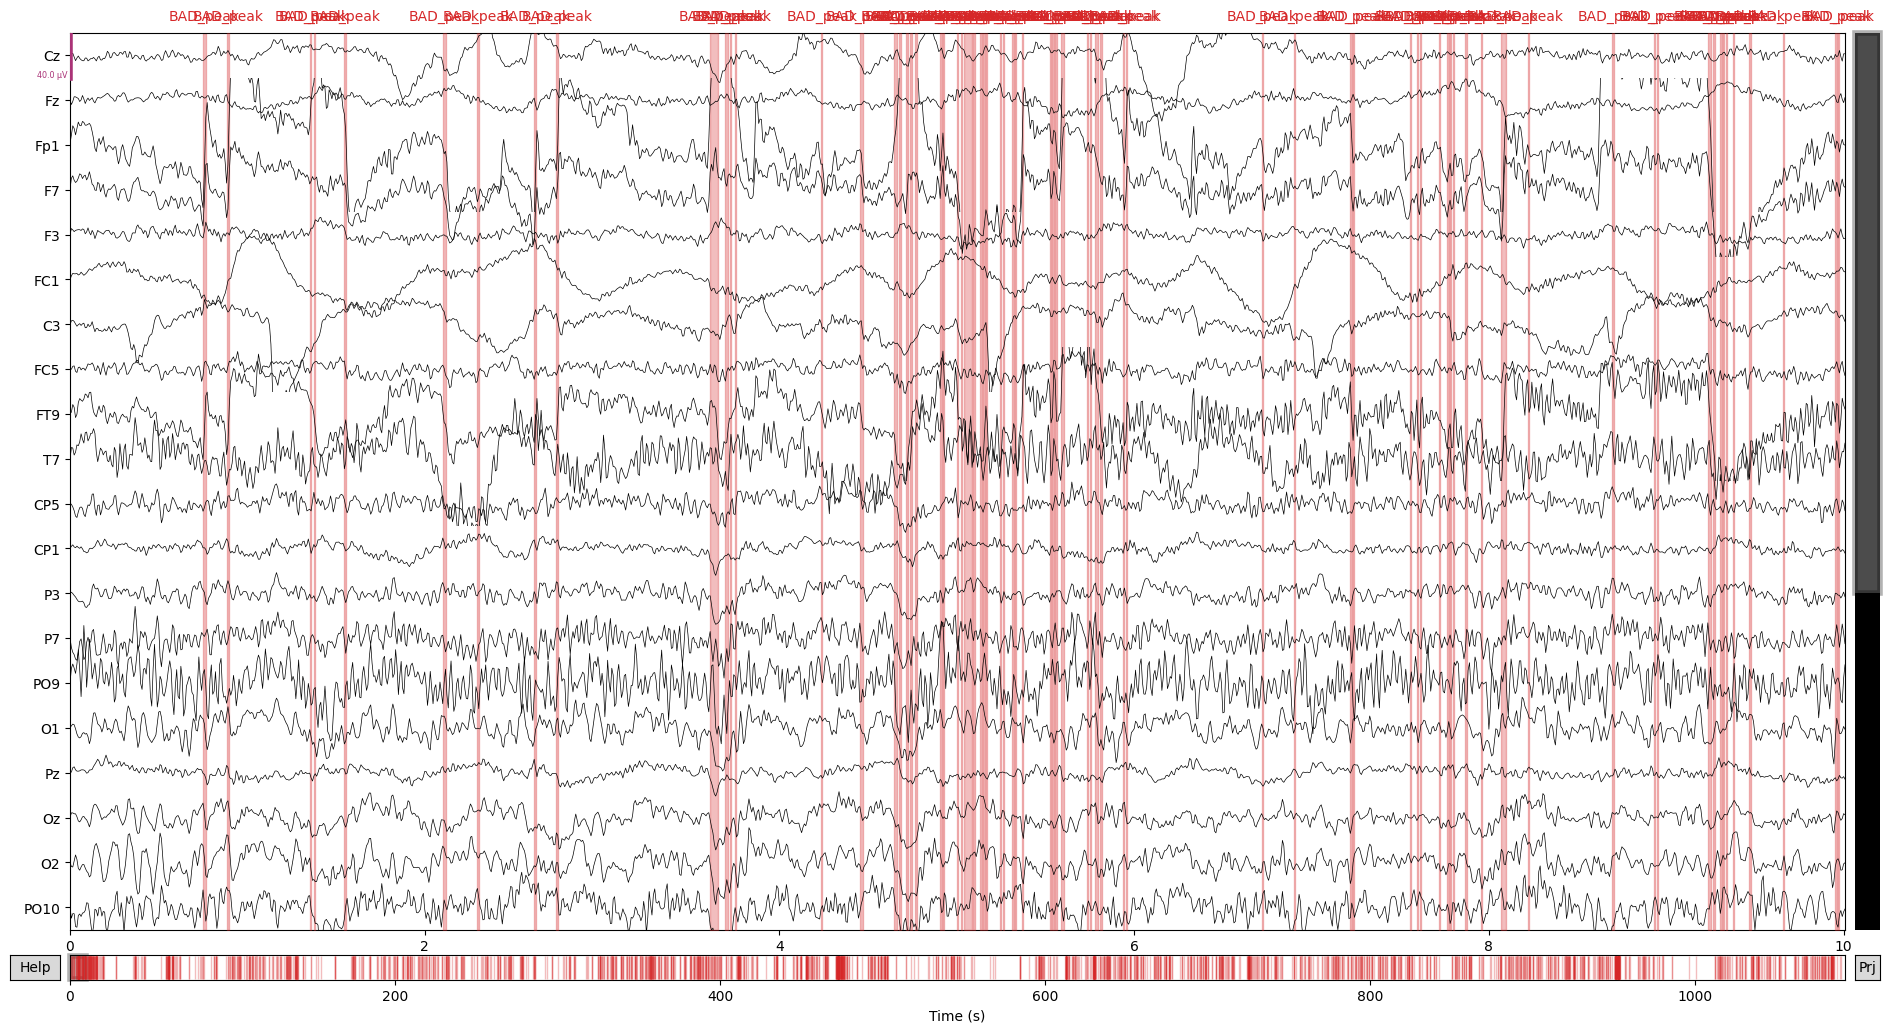

Number of annotations: 2031


In [33]:
import mne
import numpy as np

# Parameters for annotation
peak = 0.00005
peak_max = 10
flat = None
bad_percent = 100 # This is the threshold over which a channel will simply be marked as bad!
bad_percent_max = 100
min_duration = 0.009 # Our minimum duration is 1/128 = 0.0078125 seconds
min_duration_max = 2
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
picks = eeg_channels
verbose = True

# Read your EDF file
raw = mne.io.read_raw_edf(r'EDF+\Zacker\Zacker.edf', preload=True, verbose=True, infer_types=True)
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']

# Select only EEG channels
raw.pick_channels(eeg_channels)

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')

# Apply preprocessing steps
raw.set_eeg_reference('average', projection=True)  # set EEG average reference
raw.filter(l_freq=1, h_freq=40)  # Apply band-pass filter

# Compute peak-to-peak max for each EEG channel
ptp_max_values = {}

for ch in eeg_channels:
    # Get the data for the channel
    ch_data = raw.get_data(picks=ch)
    # Compute the peak-to-peak value
    ptp_value = np.ptp(ch_data)
    ptp_max_values[ch] = ptp_value

# Print the peak-to-peak max values for each channel
for ch, ptp_value in ptp_max_values.items():
    print(f"Channel {ch}: Peak-to-Peak Max = {ptp_value}")

# Define the annotation function with parameter adjustments
def annotate_amplitude():
    global ptp_max_values, flat, bad_percent, min_duration, raw
    annotations_found = False
    peak_factor = 1/40  # You can adjust this factor as needed

    for ch, ptp_value in ptp_max_values.items():
        peak = ptp_value * peak_factor
        print(f"Trying peak: {peak} for channel: {ch}")

        annotations, bad_segments = mne.preprocessing.annotate_amplitude(
            raw, 
            peak=peak, 
            flat=flat, 
            bad_percent=bad_percent, 
            min_duration=min_duration, 
            picks=[ch], 
            verbose=True
        )

        if len(annotations) > 2:
            annotations_found = True
            # break

    if annotations_found:
        print(f"Annotations found with peak: {peak}, bad_percent: {bad_percent}")
        bad_annotations = mne.Annotations(onset=annotations.onset, duration=annotations.duration, description=annotations.description, orig_time=raw.info['meas_date'])
        raw.set_annotations(bad_annotations)
        return annotations, len(annotations)
    else:
        print("No annotations found after iterating through all channels.")
        return None, 0

# Run the annotation function
annotations, num_annotations = annotate_amplitude()

raw.plot(title='Raw EEG Data', block=True)
print('Number of annotations:', num_annotations)
